# Evaluation - 40% training data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from pycm import ConfusionMatrix

## Insight in the training process

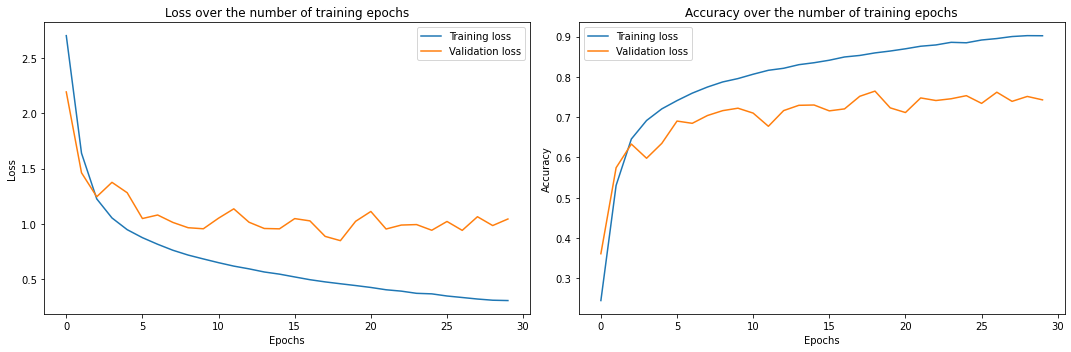

In [2]:
# Fetch training history
training_history = np.load("../results/(resnet-6-block-train40)_training_history.npy", allow_pickle=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Plot loss results
ax1.plot(training_history.item().get("loss"), label="Training loss")
ax1.plot(training_history.item().get("val_loss"), label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss over the number of training epochs")
ax1.legend()

# Plot accuracy results
ax2.plot(training_history.item().get("accuracy"), label="Training loss")
ax2.plot(training_history.item().get("val_accuracy"), label="Validation loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy over the number of training epochs")
ax2.legend()

plt.tight_layout()
plt.show()

## Performance on test data

In [3]:
def process_predictions(test_predictions, test_labels, one_hot_mapping):
    predictions = []
    labels = []

    for pred, label in zip(test_predictions, test_labels):
        pred_index = np.argmax(pred)
        predictions.append(one_hot_mapping[pred_index])

        truth_index = np.argmax(label)
        labels.append(one_hot_mapping[truth_index])
        
    return predictions, labels    

In [4]:
# Load test predictions
test_predictions = np.load("../results/(resnet-6-block-train40)_predictions.npy")

# Load test labels
test_labels = np.load("../results/(resnet-6-block-train40)_test_labels.npy")

# Load one-hot-mapping
one_hot_mapping = np.load("one_hot_mapping.npy", allow_pickle=True)

In [5]:
# Process predictions to their original labels
predictions, labels = process_predictions(test_predictions, test_labels, one_hot_mapping)

In [6]:
# Show the classification report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

    backward       0.91      0.68      0.78       167
         bed       0.85      0.55      0.67       201
        bird       0.82      0.73      0.77       206
         cat       0.54      0.81      0.65       203
         dog       0.86      0.52      0.65       213
        down       0.59      0.81      0.68       392
       eight       0.75      0.88      0.81       378
        five       0.71      0.71      0.71       405
      follow       0.73      0.47      0.57       158
     forward       0.76      0.51      0.61       156
        four       0.72      0.80      0.76       373
          go       0.69      0.63      0.66       388
       happy       0.68      0.83      0.75       205
       house       0.74      0.82      0.78       211
       learn       0.65      0.53      0.59       158
        left       0.68      0.82      0.74       380
      marvin       0.81      0.63      0.71       210
        nine       0.80    

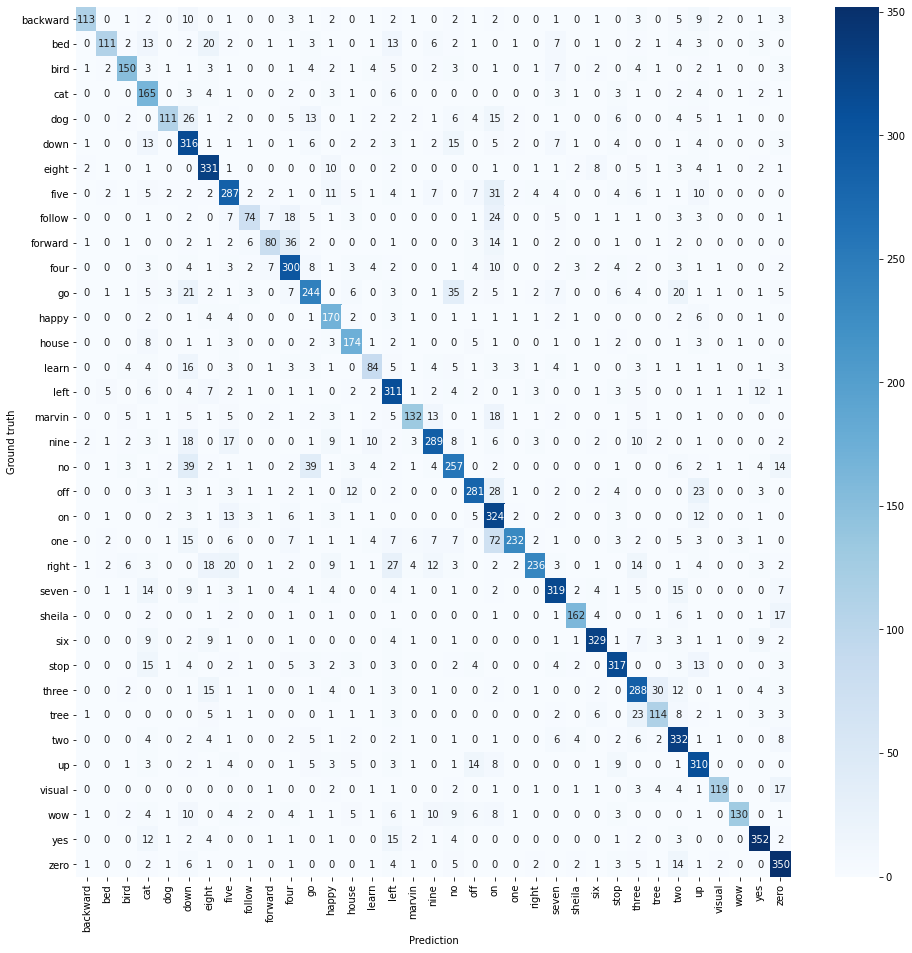

In [7]:
# Construct and show confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

plt.figure(figsize = (16,16))
sn.heatmap(conf_matrix, annot=True, xticklabels=one_hot_mapping, yticklabels=one_hot_mapping, fmt='g', cmap='Blues')
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
plt.show()

## FAR - FRR results

In [8]:
cm = ConfusionMatrix(labels, predictions)
cm.stat(overall_param=["FPR Macro","FPR Micro","FNR Macro","FNR Micro"],class_param=None)

Overall Statistics : 

FNR Macro                                                         0.27422
FNR Micro                                                         0.25409
FPR Macro                                                         0.0075
FPR Micro                                                         0.00747

Class Statistics :

Classes                                                           backward      bed           bird          cat           dog           down          eight         five          follow        forward       four          go            happy         house         learn         left          marvin        nine          no            off           on            one           right         seven         sheila        six           stop          three         tree          two           up            visual        wow           yes           zero          
ACC(Accuracy)                                                     0.99386       0.9897        0.9915    

/home/djesse/anaconda3/envs/asr/lib/python3.8/site-packages/pycm/pycm_obj.py:182: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


I used [this tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) to construct the ROC curve.

In [9]:
def compute_roc_curve(test_labels, test_predictions):
    far = dict()
    frr = dict()
    n_classes = 35

    # Compute fpr and tpr for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_predictions[:, i])
        fnr = 1 - tpr

        # store results
        frr[i] = fnr
        far[i] = fpr

    # First aggregate all false alarm rates
    all_far = np.unique(np.concatenate([far[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_frr = np.zeros_like(all_far)
    for i in range(n_classes):
        mean_frr += np.interp(all_far, far[i], frr[i])

    # Average the false rejection rates by the number of classes
    mean_frr /= n_classes

    far["macro"] = all_far
    frr["macro"] = mean_frr
    
    return far, frr
    
far, frr = compute_roc_curve(test_labels, test_predictions)

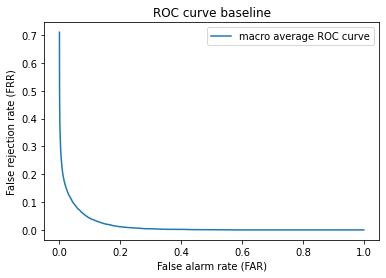

In [10]:
# Show the ROC curve
plt.plot(far['macro'], frr['macro'], label=f"macro average ROC curve")
plt.xlabel("False alarm rate (FAR)")
plt.ylabel("False rejection rate (FRR)")
plt.title("ROC curve baseline")
plt.legend()
plt.show()